In [ ]:
!pip -q install emoji emojis

     |████████████████████████████████| 175 kB 20.5 MB/s 


Reference: Emoji. PyPI. (n.d.). Retrieved May 10, 2022, from https://pypi.org/project/emoji/  

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
import nltk, re
import seaborn as sns
import string
import os, gc
import random

tqdm.pandas()

base_dir = "/content/drive/Shareddrives/602Project/Assigns"
os.listdir(base_dir)

['imdb_movies_test.csv.gz',
 'lda.gensim.state',
 'imdb_movies_val.csv.gz',
 'imdb_movies_train.csv.gz',
 'lda.gensim.id2word',
 'lda.gensim',
 'lda.gensim.expElogbeta.npy',
 'word2vec.gensim',
 'imdb_reviews_val.csv.gz',
 'imdb_reviews_test.csv.gz',
 'dataset.zip',
 'imdb_reviews_train.csv.gz',
 'imdb_movies_raw.csv.gz',
 'imdb_reviews_raw.csv.gz']

In [ ]:
mov_df = pd.read_csv(f"{base_dir}/imdb_movies_raw.csv.gz", compression="gzip")
rev_df = pd.read_csv(f"{base_dir}/imdb_reviews_raw.csv.gz", compression="gzip")

print("Movies data:")
print(mov_df.shape, mov_df.columns)

print("Reviews data:")
print(rev_df.shape, rev_df.columns)

Movies data:
(1150, 10) Index(['name', 'year', 'movie_rated', 'run_length', 'genres', 'release_date',
       'rating', 'num_raters', 'num_reviews', 'review_url'],
      dtype='object')
Reviews data:
(927096, 9) Index(['username', 'rating', 'helpful', 'total', 'date', 'title', 'review',
       'year', 'name'],
      dtype='object')


In [ ]:
# rev_df = rev_df.sample(frac=0.1)
# rev_df.shape

#### Data Cleaning & Sampling

In [ ]:
# leave run_length, release_date, name, 'year',review_url
# features = ['name', 'year', 'movie_rated','genres','rating', 'num_raters', 'num_reviews',]

In [ ]:
from sklearn.model_selection import train_test_split
mov_cv, mov_test = train_test_split(mov_df, train_size = 0.8, random_state=439)
mov_train, mov_val = train_test_split(mov_cv, train_size = 0.8, random_state=439)
print("Train:", mov_train.shape, "Val:", mov_val.shape, "Test:", mov_test.shape)

Train: (736, 10) Val: (184, 10) Test: (230, 10)


In [ ]:
import emojis
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re, emoji
nltk.download('stopwords')
nltk.download('punkt')
nltk.download("wordnet")

eng_stops = stopwords.words('english')
lemma = WordNetLemmatizer()

def preprocess_review(r):
    # r = emoji.demojize(r)
    lower_rev = r.lower()
    rev = lower_rev.encode(encoding="ascii", errors="ignore").decode()
    rev = re.sub(r"[^\'\,\_a-zA-Z\s]", " ", rev)
    rev = re.sub(r"[0-9]+|(http|https)?://(www\.)?|[\w\.-]+@[\w\.-]+|<[^>]*>", " ", rev)
    words = [x.strip() for x in word_tokenize(rev) if x not in eng_stops]
    words = [lemma.lemmatize(w.strip(".")) for w in words if len(w)>2]

    if len(words) < 10:
      return np.nan

    return "|".join(words)


def clean_review_data(df):
    
    df = df.dropna(subset=['review', 'name', 'year'])
    df = df.drop_duplicates(subset=['review', 'name', 'year'])
    df = df[~df['rating'].isin(["Null"])]
    df = df[df['review'].str.len() >= 100]
    df = df[df['review'].str.len() <= 5000]
    df['emojis'] = df['review'].progress_apply(lambda t: ",".join(list(emojis.get(t))))
    df['review'] = df['review'].progress_apply(emoji.demojize)
    df['review_words'] = df['review'].progress_apply(preprocess_review)
    df = df.dropna(subset=['review_words'])

    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Reference: NLTK stop words. pythonspot. (2021, July 22). Retrieved May 10, 2022, from https://pythonspot.com/nltk-stop-words/ 

In [ ]:
# for r in mrdf['review'].values[250:800]:
#     print(preprocess_review(r))
#     break
# mrdf['review_words'] = mrdf['review'].progress_apply(preprocess_review)

#### Clean & Save the Training data for modelling

In [ ]:
# filter the data
rev_train = rev_df[rev_df['name'].isin(mov_train['name'])].reset_index(drop=1)

# clean the date
rev_train = clean_review_data(rev_train)

print("Train:", rev_train.shape)
print("\n")

# save the date
print("Saving the cleaned Train data files...")
mov_train.to_csv(f"{base_dir}/imdb_movies_train.csv.gz", index=False, compression='gzip')
rev_train.to_csv(f"{base_dir}/imdb_reviews_train.csv.gz", index=False, compression='gzip')

  0%|          | 0/508676 [00:00<?, ?it/s]

  0%|          | 0/508676 [00:00<?, ?it/s]

  0%|          | 0/508676 [00:00<?, ?it/s]

Train: (507092, 11)


Saving the cleaned Train data files...


#### Clean & Save the Val & Test data for modelling

In [ ]:
# filter
rev_val = rev_df[rev_df['name'].isin(mov_val['name'])].reset_index(drop=1)
rev_test = rev_df[rev_df['name'].isin(mov_test['name'])].reset_index(drop=1)

# clean
rev_val = clean_review_data(rev_val)
rev_test = clean_review_data(rev_test)

print("Val:", rev_val.shape, "Test:", rev_test.shape)
print("\n")

# save
print("Saving the cleaned Val/Test data files...")
# mov_train.to_csv(f"{base_dir}/imdb_movies_train.csv.gz", index=False, compression='gzip')
# rev_train.to_csv(f"{base_dir}/imdb_reviews_train.csv.gz", index=False, compression='gzip')

mov_val.to_csv(f"{base_dir}/imdb_movies_val.csv.gz", index=False, compression='gzip')
mov_test.to_csv(f"{base_dir}/imdb_movies_test.csv.gz", index=False, compression='gzip')

rev_val.to_csv(f"{base_dir}/imdb_reviews_val.csv.gz", index=False, compression='gzip')
rev_test.to_csv(f"{base_dir}/imdb_reviews_test.csv.gz", index=False, compression='gzip')

  0%|          | 0/143019 [00:00<?, ?it/s]

  0%|          | 0/143019 [00:00<?, ?it/s]

  0%|          | 0/143019 [00:00<?, ?it/s]

  0%|          | 0/142491 [00:00<?, ?it/s]

  0%|          | 0/142491 [00:00<?, ?it/s]

  0%|          | 0/142491 [00:00<?, ?it/s]

Val: (142432, 11) Test: (142018, 11)


Saving the cleaned Val/Test data files...


In [ ]:
del rev_val, rev_test
del mov_val, mov_test
gc.collect()

783

### EDA/Data Analysis

<BarContainer object of 10 artists>

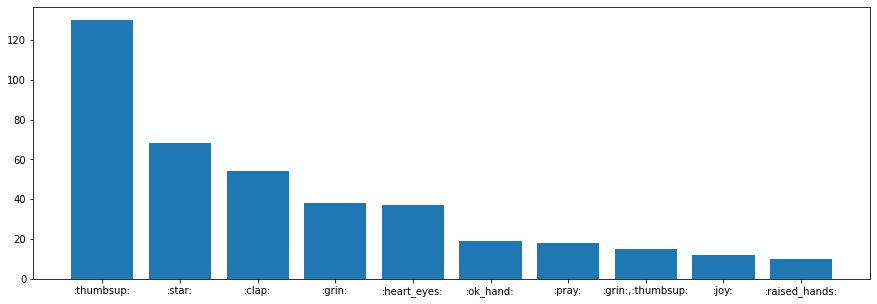

In [ ]:
all_emojis = rev_train['emojis'].values.ravel().tolist()
all_emojis = [e for e in all_emojis if len(e)]
emoji_counts = Counter(all_emojis)
v, h = zip(*emoji_counts.most_common(10))
x = [emojis.decode(e) for e in v]
plt.figure(figsize=(15,5))
plt.bar(x, h)

  0%|          | 0/507092 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distrubution of Length of Reviews Sentences.')

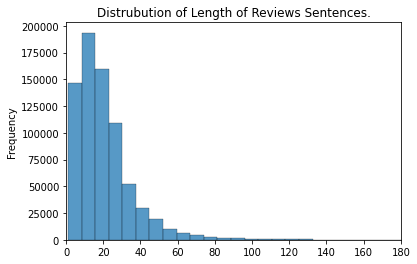

In [ ]:
all_sent_lens = []
num_sents = []
for t in tqdm(rev_train['review'].values):
    sents = nltk.sent_tokenize(t)
    num_sents.append(len(sents))
    for sent in sents:
        all_sent_lens.append(len(sent.split(" ")))
        
ax = sns.histplot(all_sent_lens, stat='frequency', bins=120)
_ = ax.axis(xmin=0, xmax=180)
ax.set_title("Distrubution of Length of Reviews Sentences.")

mean number of sentences per each review: 20.63147212676654




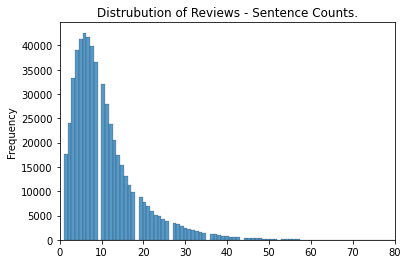

In [ ]:
ax = sns.histplot(num_sents, stat='frequency', bins=200)
_ = ax.axis(xmin=0, xmax=80)
ax.set_title("Distrubution of Reviews - Sentence Counts.")
print("mean number of sentences per each review:", np.mean(all_sent_lens))
print("\n")

In [ ]:
del all_sent_lens, num_sents
gc.collect()

238

In [ ]:
review_words = rev_train['review_words'].values

In [ ]:
from wordcloud import WordCloud

def plot_word_cloud(freq_counter, max_words=25):
    wc = (WordCloud(max_font_size=50,max_words=max_words)
          .generate_from_frequencies(freq_counter))
    plt.figure(figsize=(9,9))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

[('movie', 1394219), ('film', 972290), ("n't", 693495), ('one', 515828), ('like', 426671)]




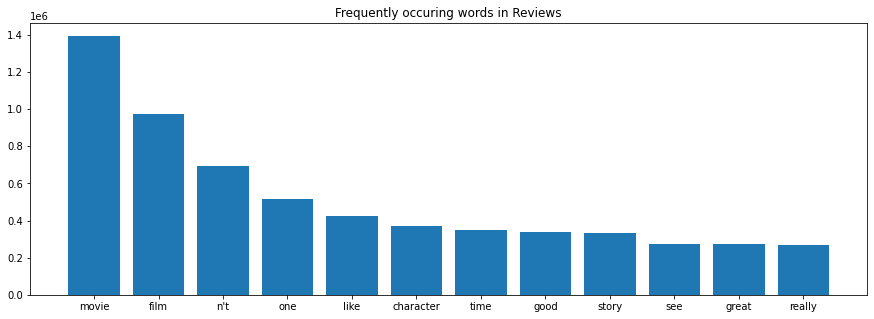

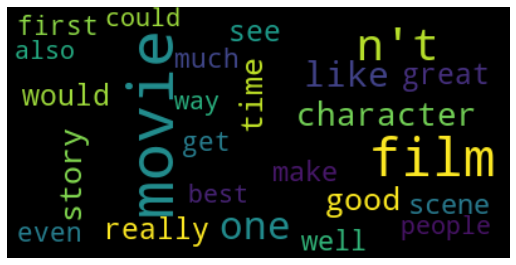

In [ ]:
from nltk.probability import FreqDist

all_words = []
for r in review_words:
    ws = r.split("|")
    all_words.extend(ws)

word_counts = FreqDist(all_words)
print(word_counts.most_common(5))
x, h = zip(*word_counts.most_common(12))
plt.figure(figsize=(15,5))
plt.bar(x, h)
plt.title("Frequently occuring words in Reviews")
print("\n")
_ = plot_word_cloud(word_counts)

In [ ]:
del all_words
gc.collect()
print("Less Frequent words in Reviews")
word_counts.most_common()[:-10-1:-1]

Less Frequent words in Reviews


[('ppaque', 1),
 ('cataloni', 1),
 ('bessant', 1),
 ("'planting", 1),
 ('mindbugged', 1),
 ('unlasting', 1),
 ('wihle', 1),
 ('falmouth', 1),
 ('pedos', 1),
 ('beb', 1)]

In [ ]:
# sampling to avoid out of memory issues
review_words = random.sample(list(review_words), len(review_words)//4)

In [ ]:
from nltk.util import ngrams

two_grams = []
three_grams = []
for r in review_words:
    ws = [w for w in r.split("|") if len(w)]
    try:
        two_grams.extend(['_'.join(g) for g in ngrams(ws, 2)])
        three_grams.extend(['_'.join(g) for g in ngrams(ws, 3)])
    except Exception as e:
        continue

[('star_war', 11547), ('special_effect', 9559), ("movie_n't", 8953), ('one_best', 8882), ("could_n't", 7157)]




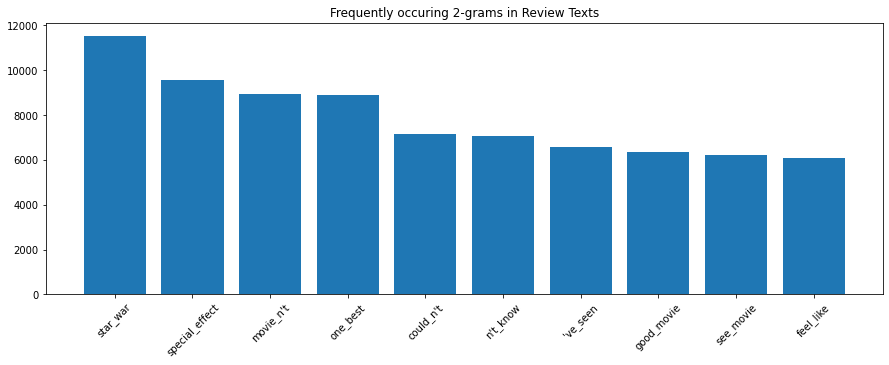

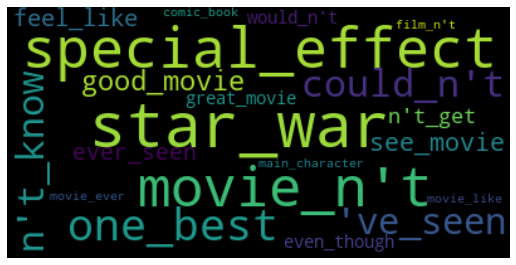

In [ ]:
gram_counts = FreqDist(two_grams)
print(gram_counts.most_common(5))
x, h = zip(*gram_counts.most_common(10))
plt.figure(figsize=(15,5))
plt.bar(x, h)
plt.xticks(rotation=45)
_ = plt.title("Frequently occuring 2-grams in Review Texts")

print("\n")

_ = plot_word_cloud(gram_counts, 20)

[("'ve_ever_seen", 2377), ('one_best_movie', 1773), ('movie_ever_made', 1540), ('star_war_movie', 1496), ('best_movie_ever', 1267)]




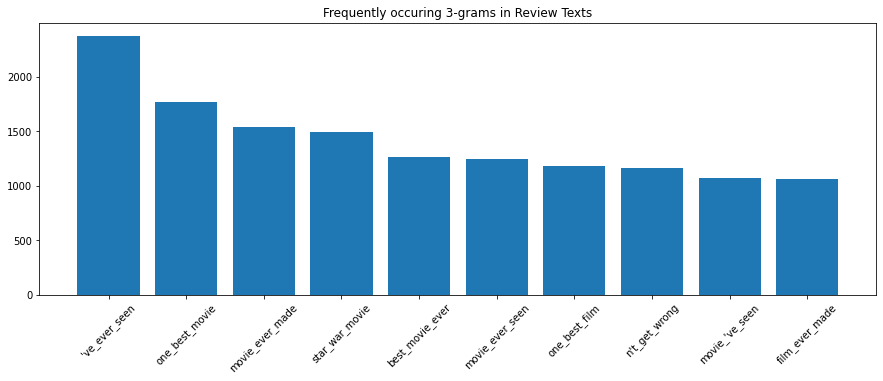

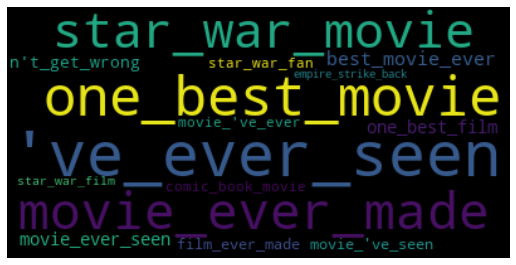

In [ ]:
gram_counts = FreqDist(three_grams)
print(gram_counts.most_common(5))
x, h = zip(*gram_counts.most_common(10))
plt.figure(figsize=(15,5))
plt.bar(x, h)
plt.xticks(rotation=45)
_ = plt.title("Frequently occuring 3-grams in Review Texts")

print("\n")

_ = plot_word_cloud(gram_counts, 15)

Reference: Generating word cloud in python. GeeksforGeeks. (2021, July 5). Retrieved May 10, 2022, from https://www.geeksforgeeks.org/generating-word-cloud-python/ 

#### Notebook 3: Word2Vec & Topic Modelling on Reviews Text Data

---

